In [1]:
# -*- coding: utf-8 -*-
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset.
# implemented Simple Ensemble Learning (Averaging Classifier) using Decision Tree, K-Nearest Neighbors, and Random Forest

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder


/tmp/ipykernel_2289741/1570694996.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-02 17:24:18.619643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 17:24:18.652766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 17:

In [2]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')

In [3]:
tf.keras.backend.clear_session()

In [4]:
df = df.sample(frac=0.75, random_state=42)

In [5]:
# Extract subsample of data
print(" Extract subsample of data: ")
print(df['ALERT'].value_counts())

 Extract subsample of data: 
ALERT
Normal               11287459
Denial of Service     3854533
Port Scanning         3126882
Malware                   427
Name: count, dtype: int64


In [6]:
dropped_df = ['ALERT']
X = df.drop(dropped_df, axis=1)
y = df['ALERT']

# Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(df['ALERT'].value_counts())

ALERT
Normal               11287459
Denial of Service     3854533
Port Scanning         3126882
Malware                   427
Name: count, dtype: int64


In [7]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling is to ensure that all the features contribute equally to the result 
# and this make the computation faster and easier for the model to learn.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

 # Train the models
with strategy.scope():
    # Initialize the models inside the strategy scope
    model1 = DecisionTreeClassifier()
    model2 = KNeighborsClassifier()
    model3 = RandomForestClassifier()

    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)

    # Implemented ensemble model using VotingClassifier for combining predictions from RandomForestClassifier, KNeighborsClassifier, and DecisionTreeClassifier. The VotingClassifier utilizes soft voting, considering class probabilities. This approach provides a scikit-learn-based ensemble solution for combining diverse model predictions.
    # Additionally, manually averaged predictions were calculated for comparison. The manual averaging involved summing predicted probabilities from each model and dividing by the number of models. The final class predictions were obtained by selecting the class with the highest probability.
    # The VotingClassifier approach offers a more streamlined and scikit-learn-native solution for ensemble modeling, while the manual averaging provides flexibility for customized implementations. Both methods aim to improve prediction accuracy by leveraging multiple models.

    ensemble_model = VotingClassifier(estimators=[('rf', model1), ('knn', model2), ('dt', model3)], voting='soft')
    ensemble_model.fit(X_train_scaled, y_train)

    # Predictions
    final_class_pred_enc = ensemble_model.predict(X_test_scaled)
    


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-02 17:25:34.830180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46862 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-03-02 17:25:34.830747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46804 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


In [8]:
# # Final prediction using Simple Average (Soft Voting)
# finalpred = (pred1_tf + pred2_tf + pred3_tf) / 3

# # If finalpred is a 1D array, convert it to a 2D array
# if finalpred.ndim == 1:
#     finalpred = finalpred[:, np.newaxis]

# # Convert probabilities to class predictions
# final_class_pred_enc = np.argmax(finalpred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, final_class_pred_enc)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [9]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(final_class_pred_enc)
y_test_labels = label_encoder.inverse_transform(y_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00    770907
          Malware       1.00      1.00      1.00        85
           Normal       1.00      1.00      1.00   2257492
    Port Scanning       1.00      1.00      1.00    625377

         accuracy                           1.00   3653861
        macro avg       1.00      1.00      1.00   3653861
     weighted avg       1.00      1.00      1.00   3653861



In [10]:

# Evaluate the model
accuracy = accuracy_score(y_test, final_class_pred_enc)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


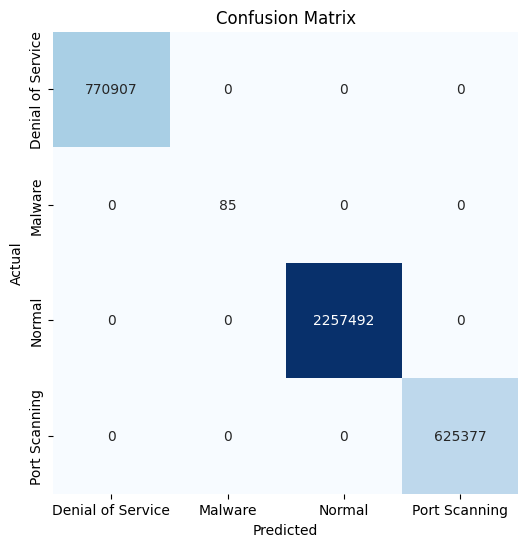

In [11]:

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()